In [16]:
# Step 1: Import all necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set default style for seaborn plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [17]:
# 2. Load Data
df = pd.read_csv("../data/MachineLearningRating_v3.txt", sep="|", low_memory=False)
df.head()


,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0


In [18]:
# 3. Preprocessing
# Create new columns required for analysis
df['Margin'] = df['TotalPremium'] - df['TotalClaims']
df['HadClaim'] = df['TotalClaims'] > 0

# Drop rows with missing values in important columns
df[['TotalPremium', 'TotalClaims', 'Margin', 'HadClaim']].head()



,TotalPremium,TotalClaims,Margin,HadClaim
0,21.929825,0.0,21.929825,False
1,21.929825,0.0,21.929825,False
2,0.000000,0.0,0.000000,False
3,512.848070,0.0,512.848070,False
4,0.000000,0.0,0.000000,False


In [19]:
# Hypothesis 1: No Risk Difference Across Provinces
# H₀: There are no risk differences across provinces

# Calculate claim frequency by Province (Claim Frequency = % of customers who had a claim)
province_group = df.groupby('Province')['HadClaim'].mean()

# Kruskal-Wallis Test: Non-parametric test for comparing more than two groups
groups = [group['HadClaim'].values for _, group in df.groupby('Province')]
stat, p = stats.kruskal(*groups)

# Display the result
print("H₀: No risk difference across provinces")
print(f"Kruskal-Wallis H-stat: {stat:.4f}, p-value: {p:.4f}")


H₀: No risk difference across provinces
Kruskal-Wallis H-stat: 104.1908, p-value: 0.0000


In [20]:
# Hypothesis 2: No Risk Difference Between Zip Codes
# H₀: There are no risk differences between zip codes

# Step 1: Filter top 10 most common zip codes (to reduce noise)
top_zips = df['PostalCode'].value_counts().head(10).index
df_top_zips = df[df['PostalCode'].isin(top_zips)]

# Step 2: Kruskal-Wallis test on HadClaim across zip codes
zip_groups = [group['HadClaim'].values for _, group in df_top_zips.groupby('PostalCode')]
stat, p = stats.kruskal(*zip_groups)

# Display the result
print("H₀: No risk difference across zip codes")
print(f"Kruskal-Wallis H-stat: {stat:.4f}, p-value: {p:.4f}")


H₀: No risk difference across zip codes
Kruskal-Wallis H-stat: 72.6492, p-value: 0.0000


In [21]:
# Hypothesis 3: No Significant Margin Difference Between Zip Codes
# H₀: There are no margin (profit) differences between zip codes

# Kruskal-Wallis test on 'Margin' across zip codes (same filtered dataset as Hypothesis 2)
zip_margin_groups = [group['Margin'].values for _, group in df_top_zips.groupby('PostalCode')]
stat, p = stats.kruskal(*zip_margin_groups)

# Display the result
print("H₀: No significant margin difference between zip codes")
print(f"Kruskal-Wallis H-stat: {stat:.4f}, p-value: {p:.4f}")


H₀: No significant margin difference between zip codes
Kruskal-Wallis H-stat: 4931.1403, p-value: 0.0000


In [22]:
# Hypothesis 4: No Risk Difference Between Women and Men
# H₀: There is no significant difference in claim risk between genders

# Step 1: Filter for Male and Female only
df_gender = df[df['Gender'].isin(['Male', 'Female'])]

# Step 2: Compare HadClaim values using independent t-test
males = df_gender[df_gender['Gender'] == 'Male']['HadClaim']
females = df_gender[df_gender['Gender'] == 'Female']['HadClaim']

# Step 3: Perform t-test (Welch's t-test assuming unequal variance)
stat, p = stats.ttest_ind(males, females, equal_var=False)

# Display the result
print("H₀: No significant risk difference between Women and Men")
print(f"T-test stat: {stat:.4f}, p-value: {p:.4f}")


H₀: No significant risk difference between Women and Men
T-test stat: 0.2055, p-value: 0.8372


In [25]:
# Create ClaimSeverity column: TotalClaims / Number of Claims (only where TotalClaims > 0)
df['ClaimSeverity'] = np.where(df['TotalClaims'] > 0, df['TotalClaims'], np.nan)
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims,Margin,HadClaim,ClaimSeverity
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,False,NaN
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,21.929825,0.0,21.929825,False,NaN
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,False,NaN
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,512.848070,0.0,512.848070,False,NaN
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,English,First National Bank,Current account,...,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,Commercial,IFRS Constant,0.000000,0.0,0.000000,False,NaN


C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:5: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


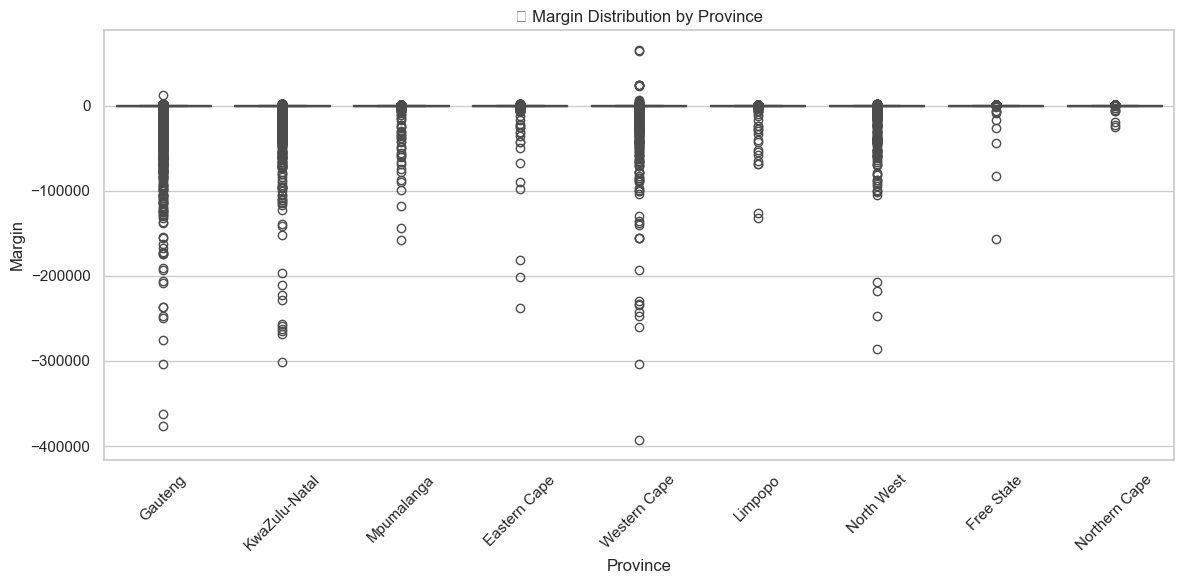

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


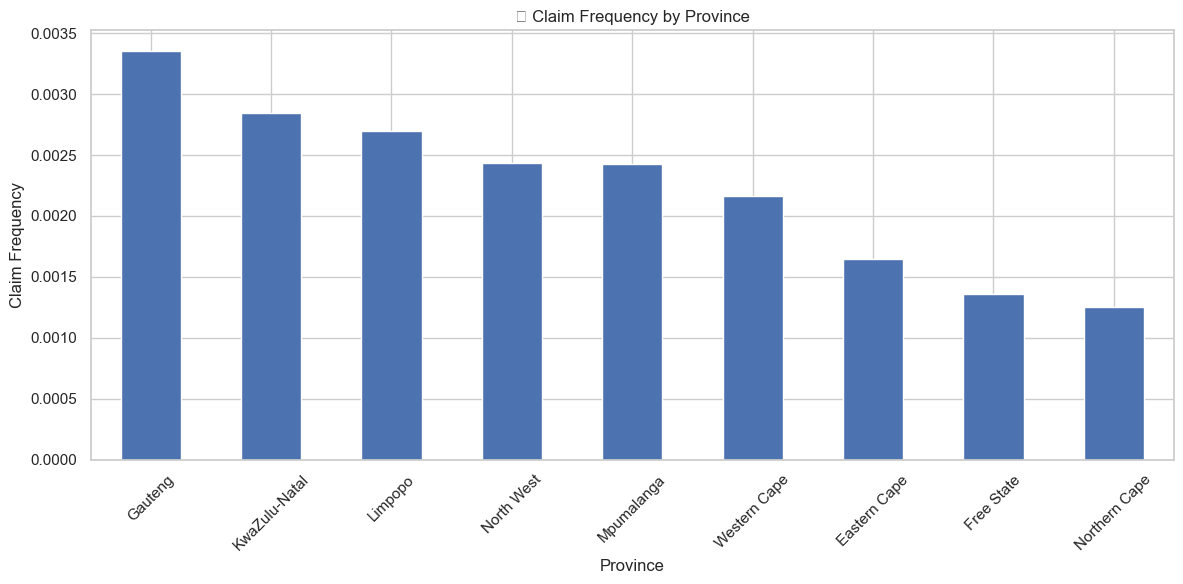

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


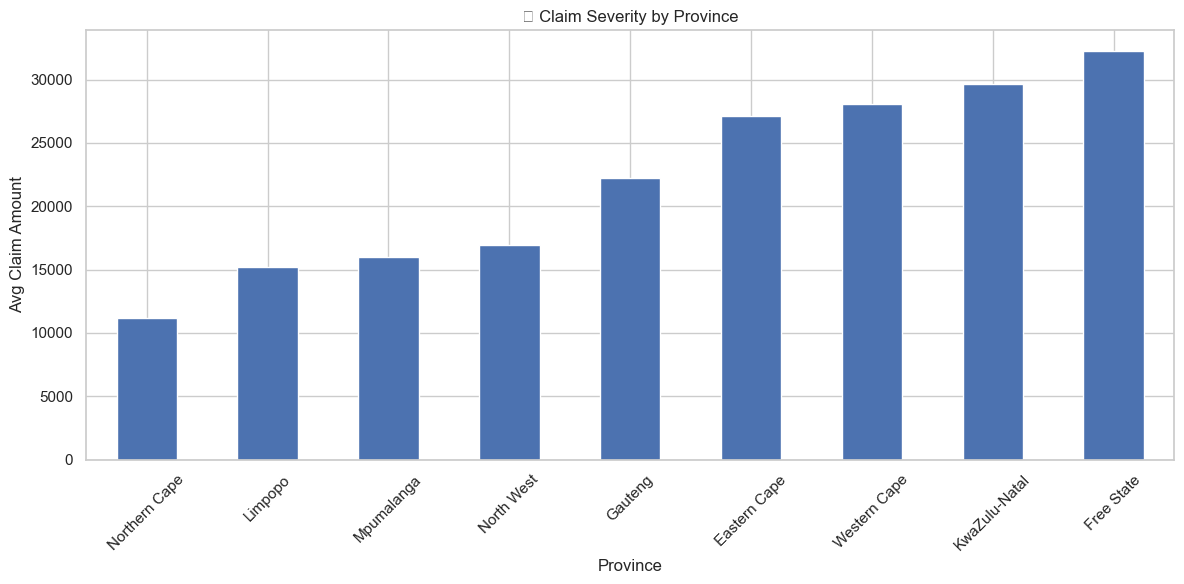

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


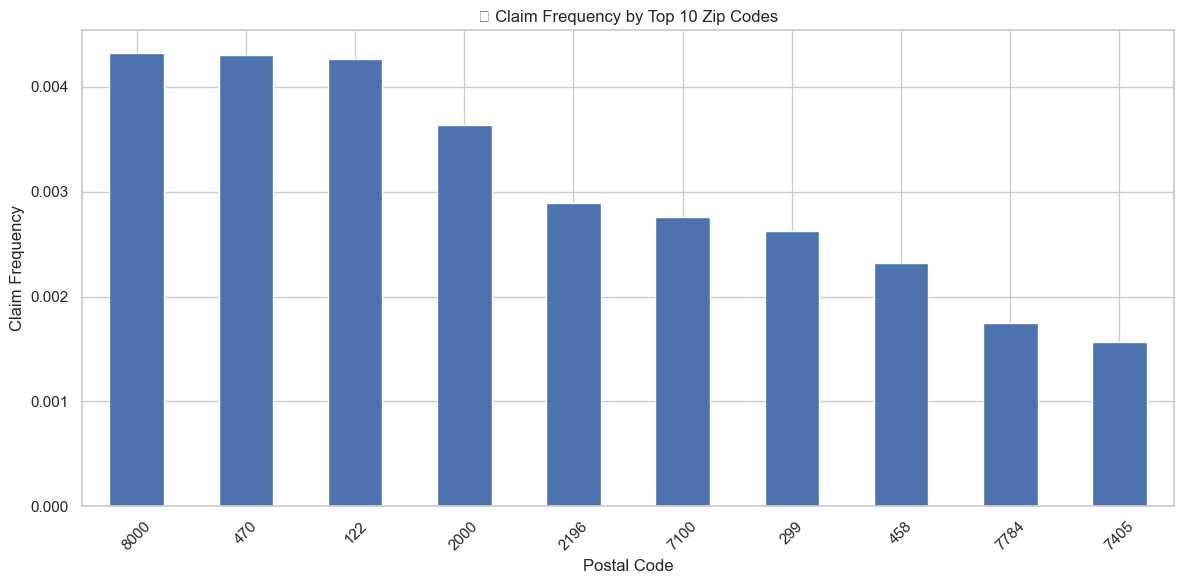

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:37: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


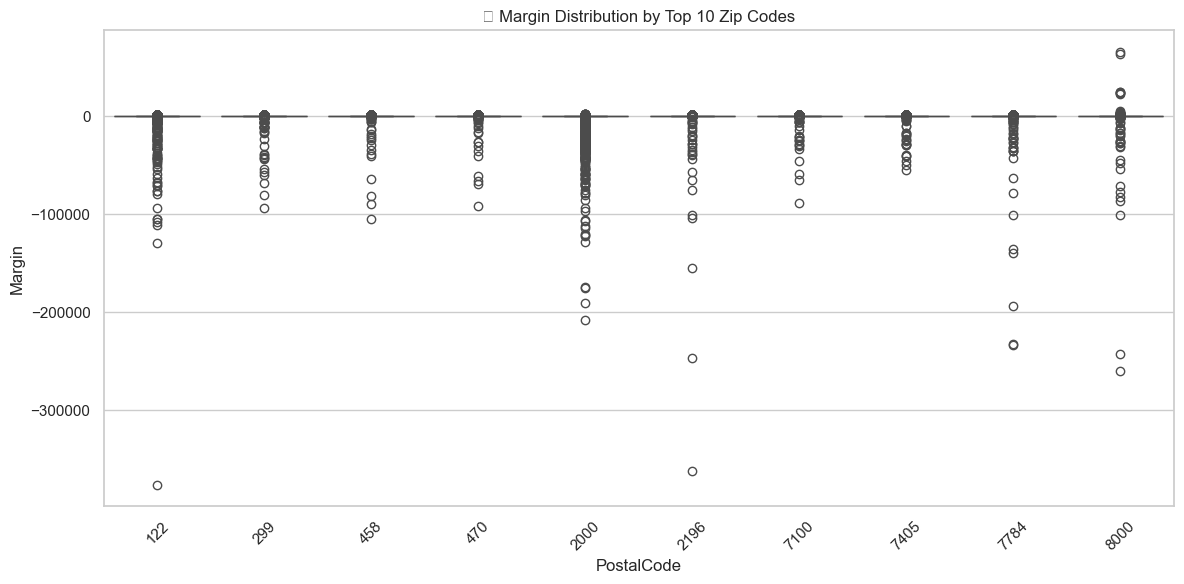

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


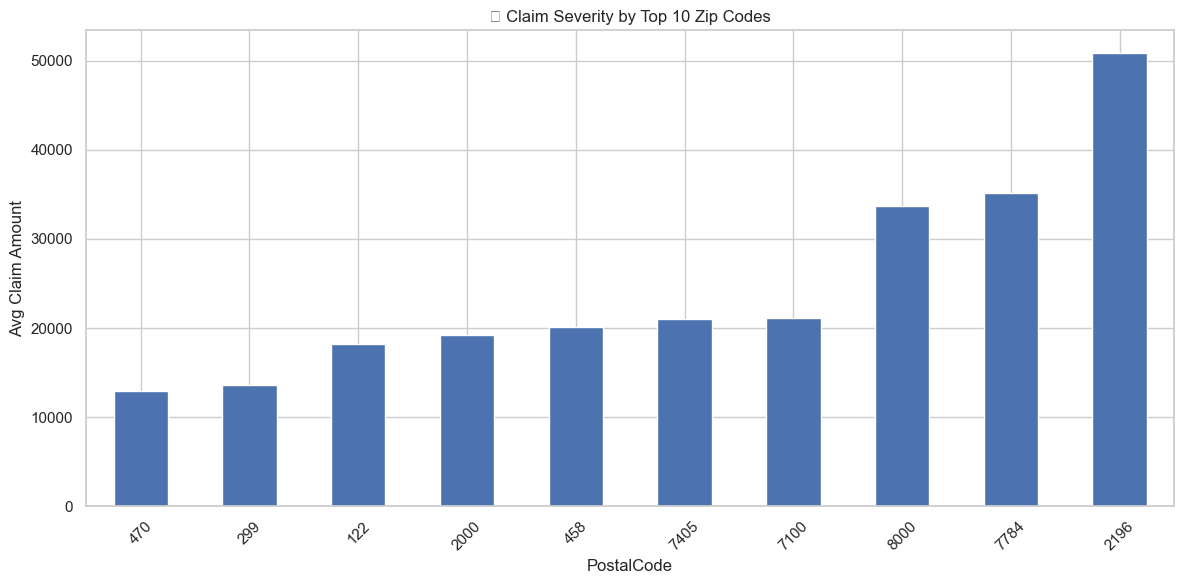

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:53: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


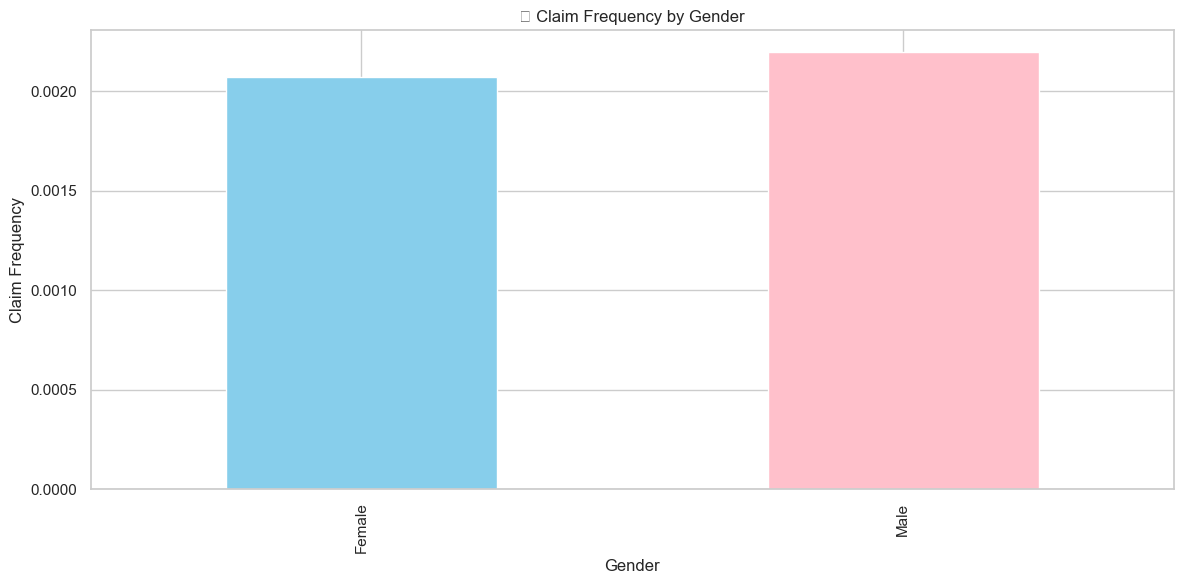

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_gender, x='Gender', y='Margin', palette="pastel")
C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:59: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


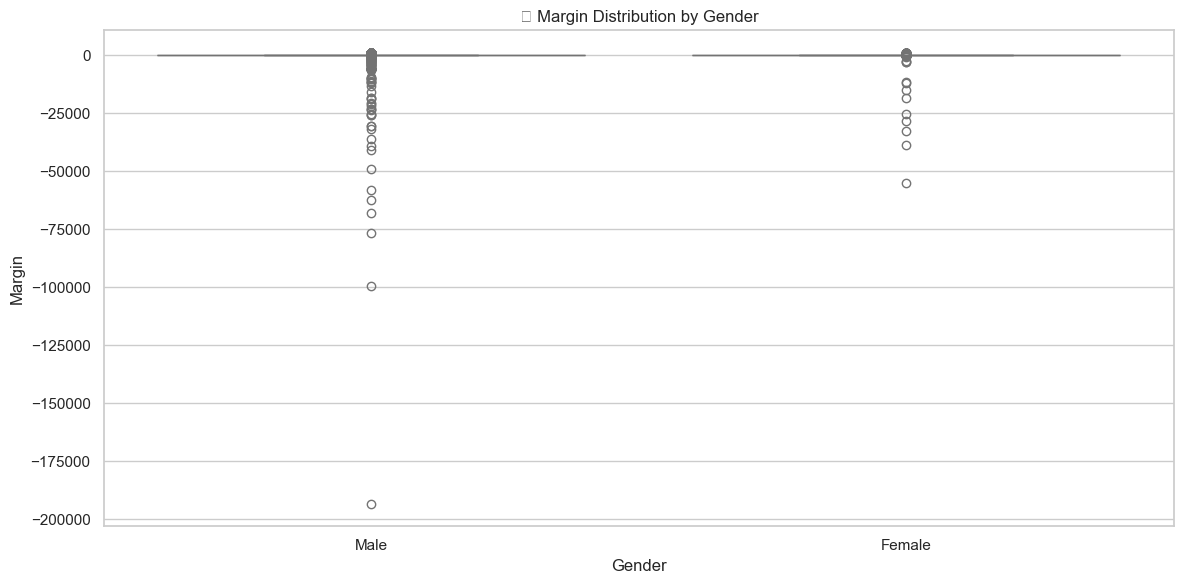

C:\Users\Administrator\AppData\Local\Temp\ipykernel_4564\2977514453.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
d:\Project\ACIS_Insurance_Analytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


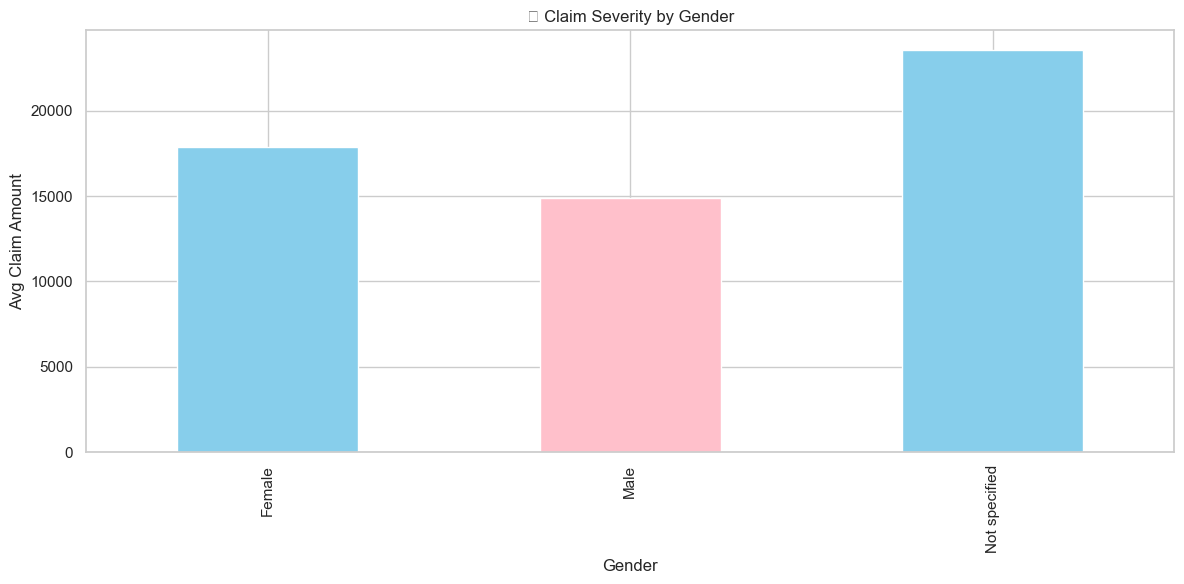

In [27]:
# BONUS: Visualization 1 — Margin distribution by Province
sns.boxplot(data=df, x='Province', y='Margin')
plt.title("📊 Margin Distribution by Province")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# BONUS: Visualization 2 — Claim frequency by Province
province_freq = df.groupby('Province')['HadClaim'].mean().sort_values(ascending=False)
province_freq.plot(kind='bar', title='📊 Claim Frequency by Province')
plt.ylabel("Claim Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Claim Severity by Province (only for rows with claims)
province_severity = df[df['TotalClaims'] > 0].groupby('Province')['ClaimSeverity'].mean().sort_values()
province_severity.plot(kind='bar', title='📊 Claim Severity by Province')
plt.ylabel("Avg Claim Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Claim Frequency by Zip Code (Top 10)
zip_freq = df_top_zips.groupby('PostalCode')['HadClaim'].mean().sort_values(ascending=False)
zip_freq.plot(kind='bar', title='📊 Claim Frequency by Top 10 Zip Codes')
plt.ylabel("Claim Frequency")
plt.xlabel("Postal Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Margin by Zip Code (Top 10)
sns.boxplot(data=df_top_zips, x='PostalCode', y='Margin')
plt.title("📊 Margin Distribution by Top 10 Zip Codes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Claim Severity by Top 10 Zip Codes
df_severity_zip = df[df['PostalCode'].isin(top_zips) & (df['TotalClaims'] > 0)]
zip_severity = df_severity_zip.groupby('PostalCode')['ClaimSeverity'].mean().sort_values()
zip_severity.plot(kind='bar', title='📊 Claim Severity by Top 10 Zip Codes')
plt.ylabel("Avg Claim Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Claim Frequency by Gender
gender_freq = df_gender.groupby('Gender')['HadClaim'].mean()
gender_freq.plot(kind='bar', color=['skyblue', 'pink'], title='📊 Claim Frequency by Gender')
plt.ylabel("Claim Frequency")
plt.tight_layout()
plt.show()

# Plot: Margin by Gender
sns.boxplot(data=df_gender, x='Gender', y='Margin', palette="pastel")
plt.title("📊 Margin Distribution by Gender")
plt.tight_layout()
plt.show()

# Plot: Claim Severity by Gender
gender_severity = df[df['TotalClaims'] > 0].groupby('Gender')['ClaimSeverity'].mean()
gender_severity.plot(kind='bar', title='📊 Claim Severity by Gender', color=['skyblue', 'pink'])
plt.ylabel("Avg Claim Amount")
plt.tight_layout()
plt.show()
